## XỬ LÝ INPUT

## --------------------------------------------------------------------------------------------------------------------------------

In [1]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

(300, 2465, 3)

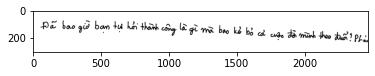

In [2]:
img = cv2.imread('../handwirtting_text2/datasets/dataset_2/images/20140603_0003_BCCTC_1.png')
plt.imshow(img)
w,h,c = img.shape
w,h,c

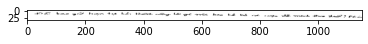

In [3]:
img_resize = cv2.resize(img,(1150,32))
plt.imshow(img_resize)

In [4]:

fh = open('../handwirtting_text2/datasets/dataset_2/transcription.pk','rb')
data = pickle.load(fh)

In [5]:
img_size = (1150, 32)
path = '../handwirtting_text2/datasets/dataset_2/images/'
chars = '\ !%"#&\'()*+,-./0123456789:;?AÁẢÀÃẠÂẤẨẦẪẬĂẮẲẰẴẶBCDĐEÉẺÈẼẸÊẾỂỀỄỆFGHIÍỈÌĨỊJKLMNOÓỎÒÕỌÔỐỔỒỖỘƠỚỞỜỠỢPQRSTUÚỦÙŨỤƯỨỬỪỮỰVWXYÝỶỲỸỴZaáảàãạâấẩầẫậăắẳằẵặbcdnđeéẻèẽẹêếểềễệfghiíỉìĩịjgklmnoóỏòõọôốổồỗộơớởờỡợpqmtrạỡởdoáhtp:?ờirstuúủùũụưứửừữựvwxyýỷỳỹỵz'

In [6]:
def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(chars.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [7]:
def loader(path,data):
    imgs,org_text = [],[]
    for sample in data:
        img = list(sample.keys())[0]
        path_img = os.path.join(path,img.split('/')[-1])
        imgs.append(path_img)
        org_text.append(list(sample.values())[0])
    return imgs,org_text

In [46]:
def processing_data_1(img):
    """
    Resize ảnh đầu vào và chuẩn hóa đầu vào
    """
    w,h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img,(new_h,new_w))
    w,h = img.shape
    img = img.astype('float32')
    #Nếu như weight ảnh nhỏ hơn 32, thì chúng ta sẽ tăng lên đúng kích thước size mình mong muốn bằng cách matrix 0
    if w < 32:
        add_zeros = np.full((32 - w,h),255)
        img = np.concatenate((img,add_zeros))
        w,h = img.shape
    #Nếu như height ảnh nhỏ hơn 1150, thì chúng ta sẽ tăng kích thước size mình mong muốn bằng cách thêm matrix 0
    if h < 1150:
        add_zeros = np.full((w,1150 - h),255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
    #Nếu như lớn hơn mình resize ảnh đúng kích thước mình mong muốn
    if w > 32 or h > 1150:
        dim = (1150,32)
        img = img.resize(img,dim)
    
    #Chuẩn hóa images
    img = cv2.subtract(255, img)
    img = np.expand_dims(img, axis=2)
    img = img / 255
    
    return img
def processing_data(img):
        height, width = img.shape
        img = cv2.resize(img,(int(32/height*width),32))
        height, width = img.shape
#         img = img.astype('float32')
        img = np.pad(img, ((0,0),(0, 1150-width)), 'median')
        img = cv2.GaussianBlur(img, (5,5), 0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 4)
        img = np.expand_dims(img , axis = 2)
        img = img/255.0
        return img

In [26]:
from sklearn.model_selection import train_test_split
training,valid = train_test_split(data,test_size=0.2,random_state=0)

In [27]:
train_imgs,org_txt = loader(path,training)
valid_imgs,valid_txt = loader(path,valid)

In [28]:
train_dict_path_img_txt = {}
for idx in range(len(train_imgs)):
    train_dict_path_img_txt[train_imgs[idx]] = org_txt[idx]

In [29]:
valid_dict_path_img_txt = {}
for idx in range(len(valid_imgs)):
    valid_dict_path_img_txt[valid_imgs[idx]] = valid_txt[idx]

In [30]:
def data_generation(data_path,dict_path_img_txt):
    max_label_len = 0
    images = []
    labels = []
    input_length = []
    label_length = []
    org_train_text = []
    
    for path_img in data_path:
        img = cv2.imread(path_img,cv2.IMREAD_GRAYSCALE)
        words = dict_path_img_txt[path_img]
        
        img = processing_data(img)
        
        label = encode_to_labels(words)
        
        if len(words) > max_label_len:
            max_label_len = len(words)
        
        images.append(img)
        labels.append(label)
        input_length.append(245)
        label_length.append(len(words))
        org_train_text.append(words)
    return images,labels,input_length,label_length,org_train_text,max_label_len

In [31]:
train_images,train_labels,train_input_length,train_label_length,org_train_text,max_label_len_train= data_generation(list(train_dict_path_img_txt.keys()),train_dict_path_img_txt)
valid_images,valid_labels,valid_input_length,valid_label_length,org_valid_text,max_label_len_valid = data_generation(list(valid_dict_path_img_txt.keys()),valid_dict_path_img_txt)

In [32]:
#Chúng ta sẽ chuyển đổi một danh sách chứa các chuỗi đưa về nó cùng một độ dài
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len_train, 
                             padding='post',
                             value=len(chars))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len_train, 
                             padding='post',
                             value=len(chars))

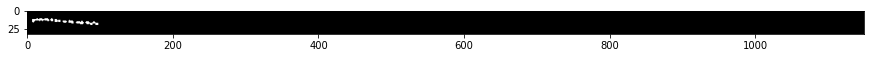

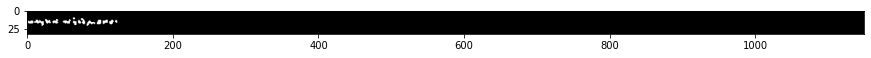

In [33]:
for i in range(2):
    plt.figure(figsize=(15,2))
    plt.imshow(train_images[i][:,:,0], cmap="gray")
    plt.show()

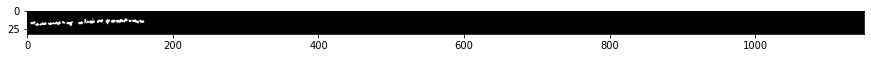

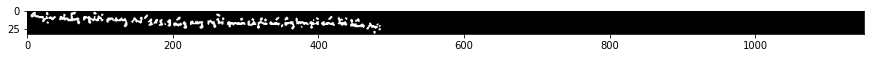

In [47]:
for i in range(2):
    plt.figure(figsize=(15,2))
    plt.imshow(valid_images[i][:,:,0], cmap="gray")
    plt.show()

In [36]:
len(train_images)

5836

In [41]:
train_images = np.array(train_images)
valid_images = np.array(valid_images)

train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [45]:
with open('train_images.pk', 'wb') as handle:
    pickle.dump(train_images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('train_padded_label.pk', 'wb') as handle:
    pickle.dump(train_padded_label, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('train_input_length.pk', 'wb') as handle:
    pickle.dump(train_input_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('train_label_length.pk', 'wb') as handle:
    pickle.dump(train_label_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
#----------------------------------------------------------------------------------
with open('valid_images.pk', 'wb') as handle:
    pickle.dump(valid_images, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('valid_padded_label.pk', 'wb') as handle:
    pickle.dump(valid_padded_label, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('valid_input_length.pk', 'wb') as handle:
    pickle.dump(valid_input_length, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('valid_label_length.pk', 'wb') as handle:
    pickle.dump(valid_label_length, handle, protocol=pickle.HIGHEST_PROTOCOL)